In [1]:
#自作モジュールimport
import sys
sys.path.append("C:\\Users\\yosiiiir\\Study_M2\\robo_ga_com")
import tool.tool1
import tool.fuzzy_function as ff
import tool.others_function as of
import tool.result_function as rf
import tool.robot_function as rof
import tool.ea_function as eaf

#必要な標準ライブラリimport
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt

#pymoo
from pymoo.util.misc import stack
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
#from pymoo.factory import get_termination 非推奨
from pymoo.termination import get_termination
from pymoo.util import plotting

In [2]:
# 問題設定（自作関数）
class MyProblem(Problem):
    def __init__(self,out_level1,fuzzy_rule1,set_types1,low1,high1,Kch1,out_level2,fuzzy_rule2,set_types2,low2,high2,Kch2):
        #######################変更する箇所###################################
        #fuzzy1(走行速度型)
        self.out_level1 = out_level1
        self.fuzzy_rule1 = fuzzy_rule1
        #self.fuzzy_rule1 = np.ones_like(self.fuzzy_rule1)*(-1)
        #self.fuzzy_rule1 = np.array([[[0,1,2],[0,1,1],[0,0,0]],[[1,2,2],[1,1,1],[0,0,0]],[[2,2,2],[1,1,1],[0,0,0]]])
        self.set_types1 = set_types1
        self.low1 = low1
        self.high1 = high1
        self.Kch1 = Kch1
        self.rule_Kch1 = np.any(self.fuzzy_rule1 == -1)
        self.ruch_count1 = 0
        self.ruch_countarr1 = False
        
        #fuzzy2(旋回速度型)
        self.out_level2 = out_level2
        '''self.fuzzy_rule2 = np.array([[0,0,0,0,1,2,2],
                                     [0,0,1,1,2,3,3],
                                     [0,1,1,2,3,4,4],
                                     [1,1,2,3,4,5,5],
                                     [2,2,3,4,5,5,6],
                                     [3,3,4,5,5,6,6],
                                     [4,4,5,6,6,6,6]])'''
        #self.fuzzy_rule2 = np.ones_like(self.fuzzy_rule2)*(-1)
        self.fuzzy_rule2 = fuzzy_rule2
        #self.fuzzy_rule2 = np.array([[0,1,1,2,3],
         #                            [1,1,2,3,4],
          #                           [1,2,3,4,5],
           #                          [2,3,4,5,5],
            #                         [3,4,5,5,6]])
        self.set_types2 = set_types2
        self.low2 = low2
        self.high2 = high2
        self.Kch2 = True
        self.rule_Kch2 = np.any(self.fuzzy_rule2 == -1)
        self.ruch_count2 = 0
        self.ruch_countarr2 = False
        ########################################################################
        
        #遺伝子の個数，最小，最大，Kの分割リスト
        self.n_var,self.xl,self.xu,self.divi_list = self.Ks_combine()
        
        #ここで予めファジィ制御の型を生成
        self.obj_control = rof.obj_func(fuzzy_rule1 = self.fuzzy_rule1,
                                 set_types1 = self.set_types1,
                                 out_level1 = self.out_level1,
                                 fuzzy_rule2 = self.fuzzy_rule2,
                                 set_types2 = self.set_types2,
                                 out_level2 = self.out_level2)
        
        super().__init__(n_var=self.n_var,
                         n_obj=3,
                         xl=self.xl,
                         xu=self.xu,
                         elementwise_evaluation=True
                        )
        
    def _evaluate(self, x, out, *args, **kwargs):
        lms = of.lms_produce(1,10)
        fpos_list = []
        for lm_tmp in lms:
            fpos_list.append(of.fpos_decision(lm_tmp[0],lm_tmp[1],1))
        f = []
        for i in x:
            i = i.tolist()
            if self.ruch_count1!=0 or self.ruch_count2 != 0:
                pop_set = self.Ks_divi_list(i[0:-(self.ruch_count1+self.ruch_count2)],self.divi_list)
                self.obj_control.fuzzy_produce(pop_set,lms)
                ruge_list = i[len(i[0:-(self.ruch_count1+self.ruch_count2)]):]
                self.obj_control.fuzzy_rule1 = self.rule_changer(self.obj_control.fuzzy_rule1,self.ruch_count1,
                                                        self.ruch_countarr1,ruge_list[0:self.ruch_count1])
                self.obj_control.fuzzy_rule2 = self.rule_changer(self.obj_control.fuzzy_rule2,self.ruch_count2,
                                                        self.ruch_countarr2,ruge_list[self.ruch_count1:self.ruch_count1+self.ruch_count2])
            else:
                pop_set = self.Ks_divi_list(i,self.divi_list)
                self.obj_control.fuzzy_produce(pop_set,lms)
            self.obj_control.fpos_list = fpos_list
            f.append(self.obj_control.move_to_obj())
        out["F"] = [f]
        
    def output_low_high(self,rule,set_types,low,high,Kch,out_level):
        new_low = []
        new_high = []
        division_list = []
        if set_types[-1]==0:
            end_shape = out_level
        else:
            end_shape = out_level
        shape_list = list(rule.shape)+[end_shape]
        if Kch==False:
            shape_list = [2]*len(shape_list)
            
        for r,t,l,h in zip(shape_list,set_types,low,high):
            if t==0:
                r = r//2+1
            new_low.append(l*(r-1))
            new_high.append(h*(r-1))
            division_list.append(r-1)
        return new_low,new_high,division_list
    
    def rule_change_count(self,end_level,fuzzy_rule):
        low_list = []
        high_list = []
        count = np.count_nonzero(fuzzy_rule == -1)
        count_arr = np.where(fuzzy_rule==-1)
        if not count:
            count=0
            count_arr = False
            return low_list,high_list,count,count_arr

        for i in range(count):
            low_list.append([0])
            high_list.append([end_level])
        return low_list,high_list,count,count_arr
    
    def rule_changer(self,fuzzy_rule,count,countarr,set_no):
        if count==0:
            return fuzzy_rule
        else:
            for x,y,s in zip(countarr[0],countarr[1],set_no):
                fuzzy_rule[x][y]=int(s)
        return fuzzy_rule
    
    def Ks_combine(self):
        rule_low1=[[]]
        rule_high1=[[]]
        rule_low2=[[]]
        rule_high2=[[]]
        if self.rule_Kch1:
            rule_low1,rule_high1,self.ruch_count1,self.ruch_countarr1 = self.rule_change_count(self.out_level1,self.fuzzy_rule1)
        if self.rule_Kch2:
            rule_low2,rule_high2 ,self.ruch_count2,self.ruch_countarr2= self.rule_change_count(self.out_level2,self.fuzzy_rule2)
        
        new_low1,new_high1,divi1 = self.output_low_high(self.fuzzy_rule1,self.set_types1,self.low1,self.high1,self.Kch1,self.out_level1)
        new_low2,new_high2,divi2 = self.output_low_high(self.fuzzy_rule2,self.set_types2,self.low2,self.high2,self.Kch2,self.out_level2)
        low = list(itertools.chain.from_iterable(new_low1+new_low2+rule_low1+rule_low2))
        high = list(itertools.chain.from_iterable(new_high1+new_high2+rule_high1+rule_high2))
        divi_li = divi1+divi2
        n_var = len(low)
        xl=np.array(low)
        xu=np.array(high)
        return n_var,xl,xu,divi_li

    def Ks_divi_list(self,pli,divi_li):
        Ks_list = []
        n = 0
        for d in divi_li:
            Ks_list.append(pli[n:n+d:1])
            n += d
        return Ks_list

In [3]:
optimization = True
out_level1 = 3
fuzzy_rule1 = np.array([[[0,1,2],[0,1,1],[0,0,0]],[[1,2,2],[1,1,1],[0,0,0]],[[2,2,2],[1,1,1],[0,0,0]]])
set_types1 = [1,1,1,-1]
low1 = [[math.pi/180],[1],[1],[50]]
high1 = [[math.pi/2],[500],[500],[180]]
Kch1 = True
        
#fuzzy2(旋回速度型)
out_level2 = 7
fuzzy_rule2 = np.array([[0,0,0,1,2,3,4],[0,0,1,1,2,3,4],[0,1,1,2,3,4,5],[0,1,2,3,4,5,6],[1,2,3,4,5,5,6],[2,3,4,5,5,6,6],[2,3,4,5,6,6,6]])
#fuzzy_rule2 = np.array([[0,0,0,1,2,3,4],[0,0,1,1,2,3,4],[-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1,-1,-1],[2,3,4,5,5,6,6],[2,3,4,5,6,6,6]])
set_types2 = [0,0,0]
low2 = [[math.pi/180],[1],[100]]
high2 = [[math.pi/2],[200],[200]]
Kch2 = True

if optimization:
    problem = MyProblem(out_level1,fuzzy_rule1,set_types1,low1,high1,Kch1,out_level2,fuzzy_rule2,set_types2,low2,high2,Kch2)
    # アルゴリズム初期化（NSGA-IIを使用）
    algorithm = NSGA2(
        pop_size=50,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=5),
        mutation=PolynomialMutation(prob=1.0, eta=5),
        eliminate_duplicates=False
    )
    # 終了条件（この場合は世代数）
    termination = get_termination("n_gen", 10)
    # アルゴリズムの実行
    print("GA START!")
    res = minimize(problem,
                   algorithm,
                   termination,
                   #seed=1,
                   save_history=True,
                   verbose=True)
    print("計測時間 : "+str(res.exec_time)+"[s]")

GA START!
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      3 |             - |             -
     2 |      100 |      4 |  0.8877579641 |         nadir
     3 |      150 |      4 |  0.000000E+00 |             f
     4 |      200 |     12 |  0.6387811634 |         ideal
     5 |      250 |     12 |  0.000000E+00 |             f
     6 |      300 |     13 |  0.0869565217 |         nadir
     7 |      350 |     19 |  0.2659574468 |         ideal
     8 |      400 |     22 |  0.0681818182 |         nadir
     9 |      450 |     17 |  0.2222222222 |         nadir
    10 |      500 |     24 |  0.2173913043 |         nadir
計測時間 : 77.06460189819336[s]


In [4]:
#最後の世代の個体ゲット
pop = res.pop

#個体を選ぶ
pop_no = of.pop_No_update(res,None)#Noneで合計の距離最も短い個体
#ファジィ制御更新
problem,Kis = of.fuzzy_control_new_set(problem,pop_no,pop) # pop_no = Noneでデフォルト
#problem.obj_control.fuzzy_produce(Kis,None)
#出力結果
drive_result = 0
obj_func_value_result = 0
rule_result=0
member_result=0
lms_list = []
r = 2
for i in range(1,25):
    theta = i*math.pi/12
    x = r*math.cos(theta)
    y = r*math.sin(theta)+2
    lms_list.append([x,y-2])
if drive_result:
    fpos = [1,0,math.pi/2]
    lms = np.array([[0,0],[0,0.5],[-0.5,0.5],[-0.5,-0.5],[0.5,-0.5],[0.5,0.5]])
    lms = np.array([[0,0],[0,1],[0,2],[0,4]])
    lms = np.array(lms_list)
    datas = rf.drive_test(problem,Kis,fpos,lms,20)
    
if obj_func_value_result:
    rf.print_obj_func(problem,res,1)
if rule_result or member_result:
    rf.print_result(member_result,rule_result,problem.obj_control,pop[pop_no],Kis)

pop_update -> <POP 5>


['ZO', 'P0', 'P1']


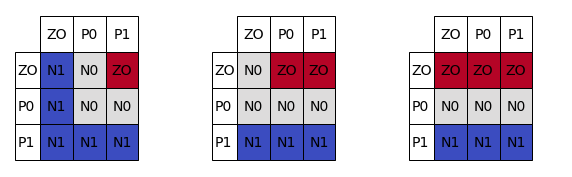

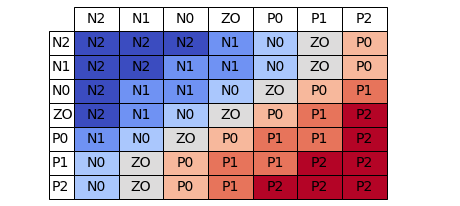

In [5]:
rf.print_result(0,1,problem.obj_control,pop[pop_no],Kis)

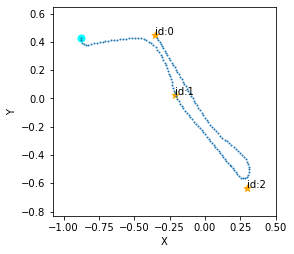

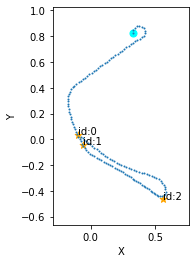

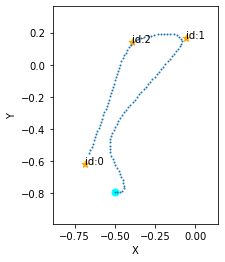

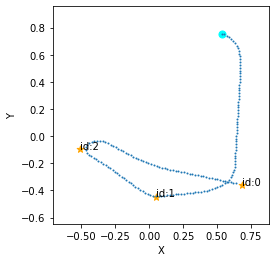

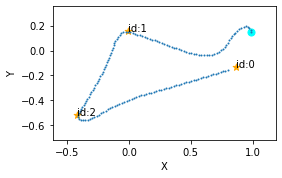

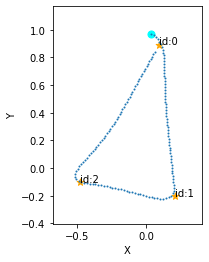

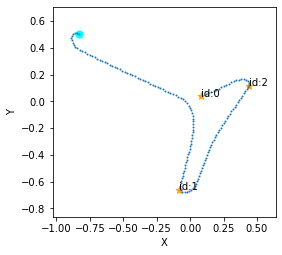

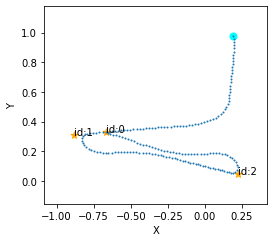

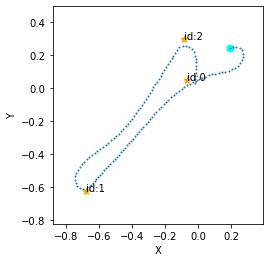

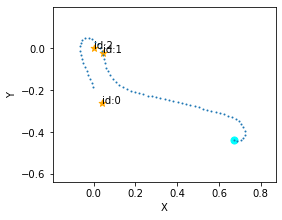

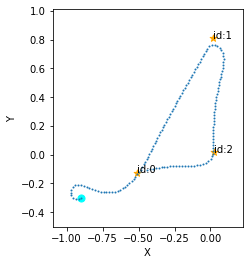

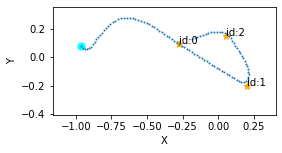

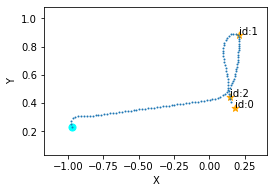

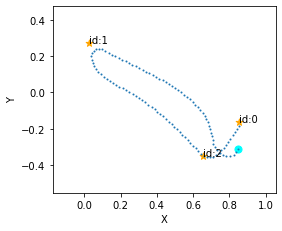

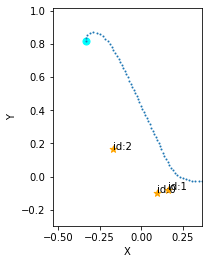

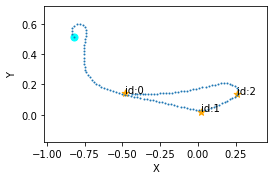

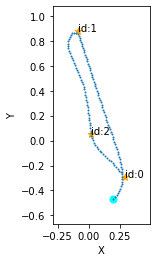

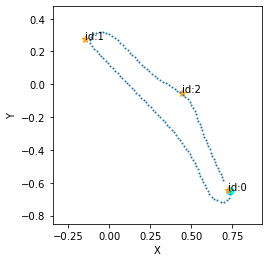

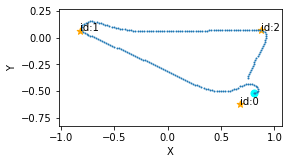

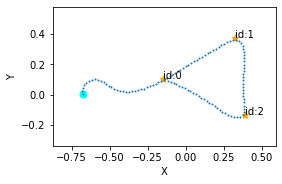

[[[ 16  80 112]
  [  2  22  50]
  [  0   0   0]]

 [[ 42 226 348]
  [ 16  78 134]
  [  0   0   0]]

 [[ 52 294 479]
  [ 28 120 176]
  [  0   0   0]]]
[[  4   2   2  21  22  10  18]
 [  3   1   7  26  26  19  31]
 [  4   3  63 198 139   9  17]
 [  2   5 212 392 184   2   4]
 [  8   7 177 240  70   3   3]
 [ 25  11  27  30   8   2   4]
 [ 17   7  27  27   2   1   3]]


In [6]:
lms =of.lms_produce(1,20)
app1_count =np.zeros_like(problem.obj_control.fuzzy1.rule)
app2_count =np.zeros_like(problem.obj_control.fuzzy2.rule)
for lm in lms:
    fpos = of.fpos_decision(lm[0],lm[1],1)
    datas = rf.drive_test(problem,Kis,fpos,lm,20)
    for x1 in problem.obj_control.fuzzy1.appearanceList:
        app1_count[x1[0]][x1[1]][x1[2]]+=1
    for x2 in problem.obj_control.fuzzy2.appearanceList:
        app2_count[x2[0]][x2[1]]+=1
print(app1_count)
print(app2_count)

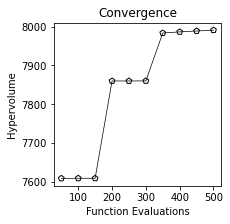

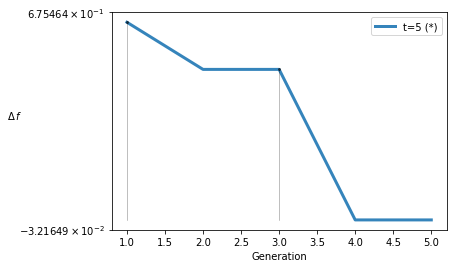

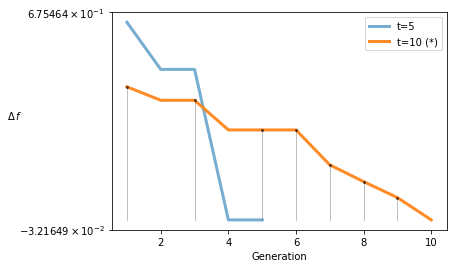

In [7]:
#アルゴリズムの性能評価
hv = 1
rm = 1
eaf.evaluation_algorithm(res,hv,rm)

In [8]:
#個体のばらつき具合確認
if False:
    eaf.print_object_space(res,problem,1,2)
    eaf.print_norm_object_space(res,1,2)
    
#個体の選択（重みバージョン）
if False:
    weights = np.array([0.6,0.2,0.2])
    eaf.print_pseudo_weights(res,weights,1,2)
    eaf.print_asf(res,weights,1,2)

In [9]:
F = res.F
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")

Scale f1: [11.45, 16.05]
Scale f2: [31.790248699799516, 152.19285214125637]


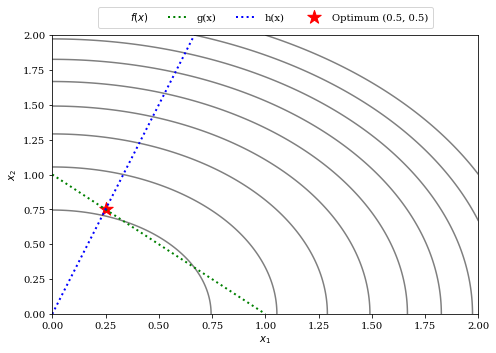

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem

class ConstrainedProblemWithEquality(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, n_eq_constr=1, xl=0, xu=1, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = x[0] + x[1]
        out["G"] = 1.0 - (x[0] + x[1])
        out["H"] = 3 * x[0] - x[1]

X1, X2 = np.meshgrid(np.linspace(0, 2, 500), np.linspace(0, 2, 500))

F = X1**2 + X2**2
plt.rc('font', family='serif')

levels = 5 * np.linspace(0, 1, 10)
plt.figure(figsize=(7, 5))
CS = plt.contour(X1, X2, F, levels, colors='black', alpha=0.5)
CS.collections[0].set_label("$f(x)$")

X = np.linspace(0, 1, 500)
plt.plot(X, 1-X, linewidth=2.0, color="green", linestyle='dotted', label="g(x)")
plt.plot(X, 3*X, linewidth=2.0, color="blue", linestyle='dotted', label="h(x)")

plt.scatter([0.25], [0.75], marker="*", color="red", s=200, label="Optimum (0.5, 0.5)")

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()


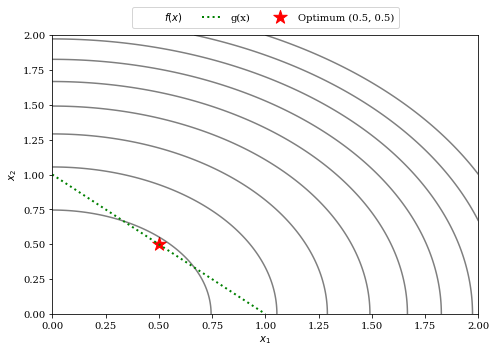

In [13]:
from pymoo.core.problem import ElementwiseProblem
import numpy as np
import matplotlib.pyplot as plt

class ConstrainedProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, n_eq_constr=0, xl=0, xu=2, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = x[0] ** 2 + x[1] ** 2
        out["G"] = 1.0 - (x[0] + x[1])

X1, X2 = np.meshgrid(np.linspace(0, 2, 500), np.linspace(0, 2, 500))

F = X1**2 + X2**2
plt.rc('font', family='serif')

levels = 5 * np.linspace(0, 1, 10)
plt.figure(figsize=(7, 5))
CS = plt.contour(X1, X2, F, levels, colors='black', alpha=0.5)
CS.collections[0].set_label("$f(x)$")

X = np.linspace(0, 1, 500)
plt.plot(X, 1-X, linewidth=2.0, color="green", linestyle='dotted', label="g(x)")

plt.scatter([0.5], [0.5], marker="*", color="red", s=200, label="Optimum (0.5, 0.5)")

plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

In [24]:
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.optimize import minimize
from pymoo.core.evaluator import Evaluator
from pymoo.core.individual import Individual

problem = ConstrainedProblem()

algorithm = DE()
termination = get_termination("n_gen", 10)
res = minimize(ConstraintsAsPenalty(problem, penalty=1),
               algorithm,
               termination,
               verbose=True)

res = Evaluator().eval(problem, Individual(X=res.X))

print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  2.5908648687 |  0.5014165601
     2 |      200 |  1.6286943117 |  0.5007860376
     3 |      300 |  1.1394726645 |  0.5002542525
     4 |      400 |  0.8815800636 |  0.5002542525
     5 |      500 |  0.7141098370 |  0.5002542525
     6 |      600 |  0.6309098603 |  0.5002542525
     7 |      700 |  0.5755332296 |  0.5002542525
     8 |      800 |  0.5604326450 |  0.5000657334
     9 |      900 |  0.5475536334 |  0.5000657334
    10 |     1000 |  0.5208676945 |  0.5000657334
Best solution found: 
X = [0.50494756 0.49357699]
F = [0.49859028]
CV = [0.00147545]


In [31]:
#res.F-res.CV
print(np.sum(res.X))
print(1-res.CV)

0.9985245499974063
[0.99852455]


In [32]:
from pymoo.core.repair import Repair

class MyRepair(Repair):

    def _do(self, problem, X, **kwargs):
        X[:, 0] = 1/3 * X[:, 1]
        return X

In [33]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

algorithm = GA(repair=MyRepair())

res = minimize(ConstrainedProblemWithEquality(),
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True)

print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      100 |  0.000000E+00 |  0.3516478340 |  1.1816456287 |  1.0001924199
     2 |      200 |  0.000000E+00 |  0.0192240408 |  1.1532524043 |  1.0001924199
     3 |      300 |  0.000000E+00 |  0.000000E+00 |  1.1005567442 |  1.0001924199
     4 |      400 |  0.000000E+00 |  0.000000E+00 |  1.0423303243 |  1.0001732916
     5 |      500 |  0.000000E+00 |  0.000000E+00 |  1.0214569210 |  1.0001143855
     6 |      600 |  0.000000E+00 |  0.000000E+00 |  1.0112639832 |  1.0001143855
     7 |      700 |  0.000000E+00 |  0.000000E+00 |  1.0063985649 |  1.0000835458
     8 |      800 |  0.000000E+00 |  0.000000E+00 |  1.0042655553 |  1.0000835458
     9 |      900 |  0.000000E+00 |  0.000000E+00 |  1.0029222610 |  1.0000804747
    10 |     1000 |  0.000000E+00 |  0.000000E+00 |  1.0017479510 |  1.0000540459
    11 |     1100 |  0.000000E+00 |  0.000000E+00 |  1.0008203740 |  1.0000448415
    12 |     120

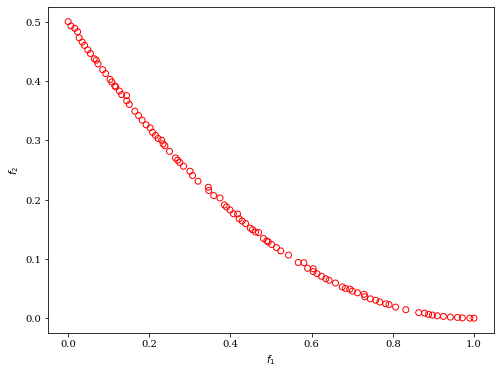

In [34]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.constraints.as_obj import ConstraintsAsObjective
from pymoo.optimize import minimize
from pymoo.problems.single import G1
from pymoo.visualization.scatter import Scatter

problem = G1()

problem = ConstrainedProblem()

algorithm = NSGA2(pop_size=100)

res = minimize(ConstraintsAsObjective(problem),
               algorithm,
               ('n_gen', 3),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()